In [38]:
import numpy as np
import json
from pprint import pprint
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
import os
import time
from skimage import io, transform
from skimage.color import rgb2gray

device = 'cuda'

In [44]:
height = 224
width = 224

In [46]:
images = np.load('augmented_images_without_extra_channels.npy').reshape(-1, 1, 224, 224)
key_numbers = np.load('key_numbers.npy')
measure_lengths = np.load('measure_lengths.npy') # 0 for 4/4 and 1 for 3/4

In [47]:
with open('pc_data.json') as f:
    pc_data = json.load(f)

In [48]:
word_to_ix = pc_data['lexicon']['word_to_ix']
ix_to_word = pc_data['lexicon']['ix_to_word']
lexicon = list(word_to_ix)
len_lexicon = len(lexicon)

In [52]:
subsequences = []
image_indices = []

seq_len = 64
ex_seq_len = seq_len + 1 # expanded to include both the sequence and the sequence shifted by 1

for i in range(images.shape[0]):
    pc = pc_data['pc'][i]
    padded_pc = [int(word_to_ix['<PAD>'])]*(ex_seq_len-2) + pc + [int(word_to_ix['<PAD>'])]*(ex_seq_len-2)
    for j in range(len(padded_pc) - ex_seq_len + 1):
        subseq = padded_pc[j:j+ex_seq_len]
        subsequences.append(subseq)
        image_indices.append(i)
        
subsequences = np.array(subsequences)
image_indices = np.array(image_indices)

In [53]:
subsequences.shape

(5353637, 65)

In [88]:
def get_time_signature_layer(measure_length, height, width):
    # measure length is 0 for 4/4 and 1 for 3/4
    x = np.zeros((height, width)).astype(np.uint8)
    if measure_length == 12:
        x[:int(height/2)] += 255
    if measure_length == 16:
        x[int(height/2):] += 255
    return x

def get_key_signature_layer(key_number, height, width):
    # key number is between -7 and 7 inclusive
    x = np.zeros((height, width)).astype(np.uint8)
    splits = np.array_split(x, 15)
    splits[key_number+7] += 255
    return x


def get_batch(batch_size):
    subsequence_batch_indices = np.random.choice(subsequences.shape[0], size=batch_size)
    subsequence_batch = subsequences[subsequence_batch_indices]
    input_sequence_batch = subsequence_batch[:, :-1]
    input_sequence_batch = torch.Tensor(input_sequence_batch).type(torch.float).to(device)
    target_sequence_batch = subsequence_batch[:, 1:]
    target_sequence_batch = torch.Tensor(target_sequence_batch).type(torch.float).to(device)

    
    image_batch_indices = image_indices[subsequence_batch_indices]
    image_batch = images[image_batch_indices]
    measure_length_batch = measure_lengths[image_batch_indices]
    key_number_batch = key_numbers[image_batch_indices]
    
    time_sig_44 = get_time_signature_layer(0, height, width)
    time_sig_34 = get_time_signature_layer(1, height, width)
    key_sig_C = get_key_signature_layer(0, height, width) # all samples here are in C
    
    time_sig_layer = np.zeros_like(image_batch)
    time_sig_layer[measure_length_batch == 0] += time_sig_44
    time_sig_layer[measure_length_batch == 1] += time_sig_34

    key_sig_layer = np.zeros_like(image_batch).reshape(-1, 1, height, width)
    key_sig_layer += key_sig_C
    
    image_batch = np.concatenate([image_batch, time_sig_layer, key_sig_layer], axis=1)
    image_batch = torch.Tensor(image_batch).type(torch.float).to(device)
    return image_batch, input_sequence_batch, target_sequence_batch, image_batch_indices

In [95]:
x, y, z, _ = get_batch(1)
x = x.cpu().numpy()
y = y.cpu().numpy()
z = z.cpu().numpy()

[[31. 31. 31. 31. 31. 31. 31. 31. 31. 31. 31. 31. 31. 31. 31. 31. 31. 31.
  31. 31. 31. 31. 31. 31. 31. 31. 31. 31. 31. 31. 31. 31. 31. 31. 31. 31.
   1. 14. 25.  5. 28. 16. 12.  8. 18. 12.  8. 27.  9.  8. 17. 30.  8.  8.
  25.  5. 24. 16.  6.  8. 18. 12.  8. 27.]]
[[31. 31. 31. 31. 31. 31. 31. 31. 31. 31. 31. 31. 31. 31. 31. 31. 31. 31.
  31. 31. 31. 31. 31. 31. 31. 31. 31. 31. 31. 31. 31. 31. 31. 31. 31.  1.
  14. 25.  5. 28. 16. 12.  8. 18. 12.  8. 27.  9.  8. 17. 30.  8.  8. 25.
   5. 24. 16.  6.  8. 18. 12.  8. 27.  9.]]


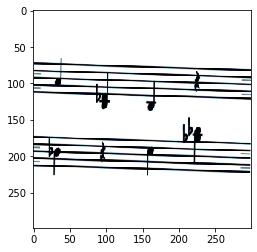

In [96]:
plt.imshow(x[0, 0, :, :], cmap='bone')
print(y)
print(z)

In [ ]:
class Net(nn.Module):
    def __init__(self, len_lexicon, lstm_hidden_size, cnn_output_size, device):
        super().__init__()
        self.len_lexicon = len_lexicon
        self.lstm_hidden_size = lstm_hidden_size
        self.cnn_output_size = cnn_output_size
        
        self.squeezenet = torchvision.models.squeezenet1_0(pretrained=True)
        self.squeezenet.classifier[1] = nn.Conv2d(512, cnn_output_size, kernel_size=(1,1), stride=(1,1))
        self.embed = nn.Embedding(num_embeddings=self.len_lexicon, embedding_dim=5)
        self.lstm1 = nn.LSTM(input_size=5, hidden_size=self.lstm_hidden_size, num_layers=2, batch_first=True, dropout=0.25)
        self.lstm2 = nn.LSTM(input_size=self.cnn_output_size+self.lstm_hidden_size, hidden_size=self.lstm_hidden_size, num_layers=2, batch_first=True, dropout=0.25)
        self.fc2 = nn.Linear(self.lstm_hidden_size, self.len_lexicon)
        
    def forward(self, image_input, language_input, internal1=None, internal2=None):
        bs = image_input.shape[0]
        sl = language_input.shape[1]
        if internal1:
            h1, c1 = internal1
        else:
            h1 = torch.zeros(2, bs, self.lstm_hidden_size).to(device)
            c1 = torch.zeros(2, bs, self.lstm_hidden_size).to(device)
        if internal2:
            h2, c2 = internal2
        else:
            h2 = torch.zeros(2, bs, self.lstm_hidden_size).to(device)
            c2 = torch.zeros(2, bs, self.lstm_hidden_size).to(device)
        image_output = self.squeezenet(image_input).view(bs, self.cnn_output_size)
        image_output = image_output.repeat(1, sl).view(bs, sl, self.cnn_output_size)
        language_output, (h1, c1) = self.lstm1(self.embed(language_input), (h1, c1))
        concatenated = torch.cat([image_output, language_output], 2)
        lstm2_out, (h2, c2) = self.lstm2(concatenated, (h2, c2))
        out = self.fc2(lstm2_out)
        return out, (h1, c1), (h2, c2)
    
    def fit(self, total_iterations, optimizer, loss_fn, rate_decay, print_every=100):
        train_start_time = time.time()
        for i in range(total_iterations):
            arr, seq1, seq2, _ = get_batch(batch_size, height, width)
            out, _, _ = self.forward(arr, seq1)
            out = out.view(-1, len_lexicon)
            targets = seq2.view(-1)
            loss = loss_fn(out, targets)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            if i % print_every == 0:
                arr, _, _, image_batch_indices = get_batch(1)
                pc = pc_data['pc'][image_batch_indices[0]]
                pc = ' '.join([ix_to_word[str(ix)] for ix in pc])
                pred_seq = self.predict(arr)
                pred_seq = ' '.join(pred_seq)
                with open('log_c_major_quarters_model_2019-09-26.txt', 'a+') as f:
                    info_string = f"""
                    ----
                    iteration: {i}
                    time elapsed: {time.time() - train_start_time}
                    loss: {loss}
                    ----
                    pred: {pred_seq}
                    ----
                    true: {pc}
                    ----



                    """.replace('    ', '')
                    print(info_string)
                    f.write(info_string)
            if i % 5000 == 0 and i != 0:
                for param_group in optimizer.param_groups:
                    param_group['lr'] *= rate_decay
                torch.save(self.state_dict(), f'c_major_quarters_model_checkpoint_iteration_{i}_2019-09-26.pt')
            
             
    def predict(self, arr):
        self.eval()    
        with torch.no_grad():
            output_sequence = ['<START>']
            h1 = torch.zeros(2, 1, self.lstm_hidden_size).to(device)
            c1 = torch.zeros(2, 1, self.lstm_hidden_size).to(device)
            h2 = torch.zeros(2, 1, self.lstm_hidden_size).to(device)
            c2 = torch.zeros(2, 1, self.lstm_hidden_size).to(device)
            while output_sequence[-1] != '<END>' and len(output_sequence)<400:
                language_input = torch.Tensor([word_to_ix[output_sequence[-1]]]).type(torch.long).view(1, 1).to(device)
                out, (h1, c1), (h2, c2) = self.forward(arr, language_input, (h1, c1), (h2, c2))
                _, language_input = out[0, 0, :].max(0)
                output_sequence.append(ix_to_word[str(language_input.item())])
        self.train()
        return output_sequence
    
    def predict_stochastic(self, arr, temperature=1):
        self.eval()    
        with torch.no_grad():
            arr = arr.view(1,3, 224, 224)
            output_sequence = ['<START>']
            h1 = torch.zeros(2, 1, self.lstm_hidden_size).to(device)
            c1 = torch.zeros(2, 1, self.lstm_hidden_size).to(device)
            h2 = torch.zeros(2, 1, self.lstm_hidden_size).to(device)
            c2 = torch.zeros(2, 1, self.lstm_hidden_size).to(device)
            while output_sequence[-1] != '<END>' and len(output_sequence)<400:
                language_input = torch.Tensor([word_to_ix[output_sequence[-1]]]).type(torch.long).view(1, 1).to(device)
                out, (h1, c1), (h2, c2) = self.forward(arr, language_input, (h1, c1), (h2, c2))
                log_probs = out[0, 0, :].cpu().numpy()*temperature
                probs = np.exp(log_probs) / np.exp(log_probs).sum()
                predicted_ix = np.random.choice(len_lexicon, p=probs)
                output_sequence.append(ix_to_word[str(predicted_ix)])
        self.train()
        return output_sequence

In [ ]:
model = Net(len_lexicon, lstm_hidden_size, cnn_output_size, device).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()

In [ ]:
# model = Net(len_lexicon, lstm_hidden_size, cnn_output_size, device).to(device)
# model.load_state_dict(torch.load('---'))